### ***Contributed by:-***

Divyanshi Bhojak(202IT007)

Tarushi Jat (202IT029)

### ***Description:*** 

Classification with CIFAR-10 dataset using Fixed Learning Rate & VGG16 Architecture.
****

### **Libraries Used**

In [ ]:
import keras
import seaborn as sns
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Convolution2D
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
import numpy as np
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
plt.style.use('ggplot')

### **Defining AdamW Optimizer**

In [ ]:
class Optimizer:
    def __init__(self, learning_rate=None, name=None):
        self.learning_rate = learning_rate
        self.name = name

    def config(self, layers):
        # sets up empty cache dictionaries 
        pass

    def optimize(self, idx, layers: list, grads: dict, *args):
        
        pass 

In [ ]:
class AdamW(Adam):  
    
    def __init__(self, learning_rate, gamma_init=1e-5, decay_rate=0.8, **kwargs):
        super().__init__(**kwargs)
        self.learning_rate = learning_rate
        self.gamma_init = gamma_init
        self.decay_rate = decay_rate
    
    def optimize(self, idx, layers, grads, epoch_num, steps):
        gamma = self.gamma_init * self.decay_rate ** int(epoch_num / 5) 
        dW = grads[f'dW{idx}']
        db = grads[f'db{idx}']
        self.m[f'W{idx}'] = self.beta1 * self.m[f'W{idx}'] + (1 - self.beta1) * dW
        self.v[f'W{idx}'] = self.beta2 * self.v[f'W{idx}'] + (1 - self.beta2) * dW ** 2 

        self.m[f'b{idx}'] = self.beta1 * self.m[f'b{idx}'] + (1 - self.beta1) * db
        self.v[f'b{idx}'] = self.beta2 * self.v[f'b{idx}'] + (1 - self.beta2) * db ** 2 

        mt_w  = self.m[f'W{idx}'] / (1 - self.beta1 ** steps)
        vt_w = self.v[f'W{idx}'] / (1 - self.beta2 ** steps)

        mt_b  = self.m[f'b{idx}'] / (1 - self.beta1 ** steps)
        vt_b = self.v[f'b{idx}'] / (1 - self.beta2 ** steps)

        w_update = - self.learning_rate * mt_w / ((np.sqrt(vt_w) + self.epsilon) + gamma * layers[idx].W) 
        b_update = - self.learning_rate * mt_b / ((np.sqrt(vt_b) + self.epsilon) + gamma * layers[idx].b)

        layers[idx].W += w_update
        layers[idx].b += b_update


### **CIFAR-10 Dataset Loading**

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


### **Performance Metrics Used**
1. Computation & cost time
2. Accuracy
3. Confusion Matrix
4. ROC Curve
5. Classification Report

In [ ]:
def perf_metrics_acc(model):
  score = model.evaluate(x_test,y_test,verbose=0)
  print("Test Loss : {:.4f}".format(score[0]))
  print("Test Accuracy : {:.2f}".format(score[1]*100),"%")

In [ ]:
def per_metrics_2(y_test, pred):
  print("*******************Classification Report*******************\n")
  print(classification_report(y_test, pred))
  print("*******************Confusion Matrix*******************\n")
  print(confusion_matrix(y_test, pred))

### **Plotting Graph Methods**

In [ ]:
def acc_plot(m):
  plt.figure(figsize=(8,5))
  sb.set_style("whitegrid")
  plt.plot(m.history['accuracy'],color="#E74C3C",marker='o')
  plt.plot(m.history['val_accuracy'],color='#641E16',marker='h')
  plt.title('Accuracy comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='best')
  plt.show()

In [ ]:
def loss_plot(m):
  plt.figure(figsize=(8,5))
  sb.set_style("whitegrid")
  plt.plot(m.history['loss'],color="#E74C3C",marker='o')
  plt.plot(m.history['val_loss'],color='#641E16',marker='h')
  plt.title('Loss comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='best')
  plt.show()

In [ ]:
def display_cm(y_test, model_pred):
  CM = confusion_matrix(y_test, model_pred)
  f, ax = plt.subplots(figsize=(8,8))
  sns.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.copper)
  plt.xlabel("Prediction(Ypred)")
  plt.ylabel("Ytrue")
  plt.show()

### **VGG-16 Architecture with Transfer Learning**

In [ ]:
def vgg_model():
  weight_decay = 0.0005
  x_shape = [32,32,3]

  model = Sequential()

  model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_shape, kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))


  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))


  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))) 
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Dropout(0.5))
  model.add(Dense(10))
  model.add(Activation('softmax'))
  return model

### **VGG16 Model Summary**

In [ ]:
model = vgg_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        2

### **Training Model with Adam Optimizer**

In [ ]:
model1 = vgg_model()
opt = keras.optimizers.Adam(lr=0.001)
model1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
vgg_adam = model1.fit(x_train, y_train, batch_size=500, epochs=50, validation_data=(x_test, y_test), shuffle=True)   #Original Epoch = 50

Epoch 1/50
100/100 [==============================] - 65s 231ms/step - loss: 5.0192 - accuracy: 0.1410 - val_loss: 4.5016 - val_accuracy: 0.1663
Epoch 2/50
100/100 [==============================] - 23s 229ms/step - loss: 4.0760 - accuracy: 0.3234 - val_loss: 4.0424 - val_accuracy: 0.2609
Epoch 3/50
100/100 [==============================] - 23s 226ms/step - loss: 3.4939 - accuracy: 0.4473 - val_loss: 3.2737 - val_accuracy: 0.4487
Epoch 4/50
100/100 [==============================] - 22s 224ms/step - loss: 3.0029 - accuracy: 0.5432 - val_loss: 3.0998 - val_accuracy: 0.4721
Epoch 5/50
100/100 [==============================] - 22s 225ms/step - loss: 2.5927 - accuracy: 0.6180 - val_loss: 2.6209 - val_accuracy: 0.5733
Epoch 6/50
100/100 [==============================] - 23s 226ms/step - loss: 2.2628 - accuracy: 0.6641 - val_loss: 2.3151 - val_accuracy: 0.6021
Epoch 7/50
100/100 [==============================] - 22s 225ms/step - loss: 1.9926 - accuracy: 0.7085 - val_loss: 1.8462 - val_ac

### **Performance Metrics Analysis for Model with Adam Optimizer**

**1. Accuracy**

In [ ]:
perf_metrics_acc(model1)

Test Loss : 1.4312
Test Accuracy : 80.57 %


**2. Classification Report & Confusion Matrix**

In [ ]:
pred = model1.predict(x_test, batch_size = 32)
pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
per_metrics_2(y_test, pred)

*******************Classification Report*******************

              precision    recall  f1-score   support

           0       0.58      0.95      0.72      1000
           1       0.84      0.95      0.89      1000
           2       0.73      0.75      0.74      1000
           3       0.89      0.47      0.62      1000
           4       0.78      0.89      0.83      1000
           5       0.89      0.69      0.78      1000
           6       0.86      0.88      0.87      1000
           7       0.89      0.89      0.89      1000
           8       0.86      0.92      0.89      1000
           9       0.99      0.66      0.79      1000

    accuracy                           0.81     10000
   macro avg       0.83      0.81      0.80     10000
weighted avg       0.83      0.81      0.80     10000

*******************Confusion Matrix*******************

[[949   5   5   0   2   0   0   4  34   1]
 [ 27 954   0   0   0   0   1   1  15   2]
 [151   0 753   5  58   8  12   7   6 

**3. Visualizing accuracy for every epoch**

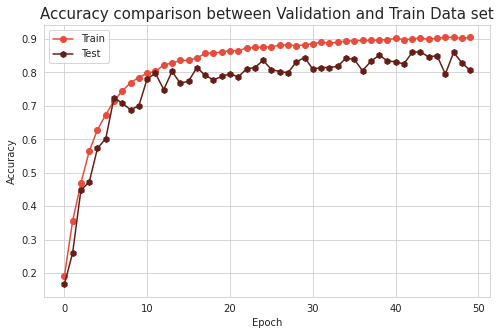

In [ ]:
acc_plot(vgg_adam)

**4. Visualizing loss in every epoch**

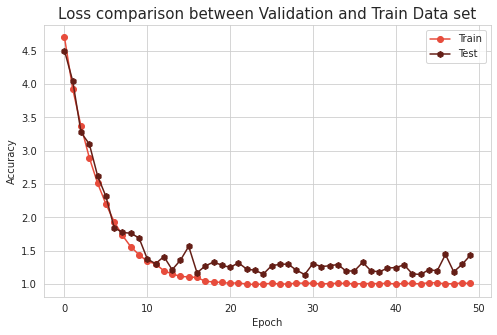

In [ ]:
loss_plot(vgg_adam)

**5. Visualizing Confusion Matrix**

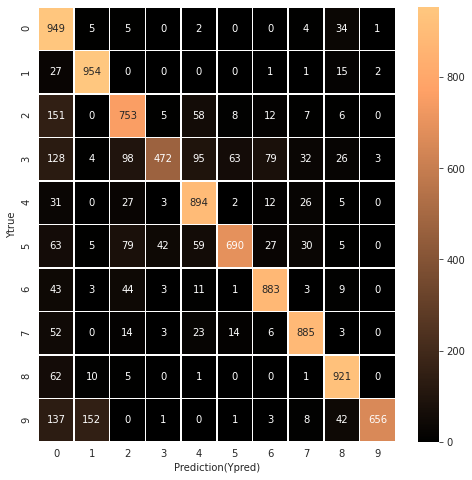

In [ ]:
display_cm(y_test, pred)

### **Training Model with SGD-M Optimizer**

In [ ]:
model2 = vgg_model()
opt = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=False)
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
vgg_sgdm = model2.fit(x_train, y_train, batch_size=500, epochs=100, validation_data=(x_test, y_test), shuffle=True)   #Original Epochs = 100

Epoch 1/100
100/100 [==============================] - 25s 232ms/step - loss: 5.4246 - accuracy: 0.1018 - val_loss: 4.4962 - val_accuracy: 0.1158
Epoch 2/100
100/100 [==============================] - 23s 227ms/step - loss: 4.8520 - accuracy: 0.1279 - val_loss: 4.4987 - val_accuracy: 0.1073
Epoch 3/100
100/100 [==============================] - 22s 223ms/step - loss: 4.5286 - accuracy: 0.1840 - val_loss: 4.4264 - val_accuracy: 0.1357
Epoch 4/100
100/100 [==============================] - 22s 223ms/step - loss: 4.3775 - accuracy: 0.2171 - val_loss: 4.4266 - val_accuracy: 0.1836
Epoch 5/100
100/100 [==============================] - 22s 225ms/step - loss: 4.2643 - accuracy: 0.2423 - val_loss: 4.3435 - val_accuracy: 0.1995
Epoch 6/100
100/100 [==============================] - 22s 225ms/step - loss: 4.1683 - accuracy: 0.2659 - val_loss: 4.3654 - val_accuracy: 0.2036
Epoch 7/100
100/100 [==============================] - 22s 224ms/step - loss: 4.0998 - accuracy: 0.2844 - val_loss: 4.3253 -

### **Performance Metrics Analysis for Model with SGD-M Optimizer**

**1. Accuracy**

In [ ]:
perf_metrics_acc(model2)

Test Loss : 2.6042
Test Accuracy : 76.92 %


**2. Classification Report & Confusion Matrix**

In [ ]:
pred = model2.predict(x_test, batch_size = 32)
pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
per_metrics_2(y_test, pred)

*******************Classification Report*******************

              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1000
           1       0.92      0.87      0.90      1000
           2       0.83      0.52      0.64      1000
           3       0.59      0.58      0.59      1000
           4       0.67      0.82      0.73      1000
           5       0.68      0.69      0.69      1000
           6       0.72      0.92      0.81      1000
           7       0.88      0.73      0.80      1000
           8       0.83      0.91      0.87      1000
           9       0.90      0.83      0.87      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000

*******************Confusion Matrix*******************

[[829  11  12  16  24   1  10  10  67  20]
 [ 13 872   0   8   1   4   9   2  36  55]
 [109   0 517  55 132  50 111  16  10 

**3. Visualizing accuracy for every epoch**

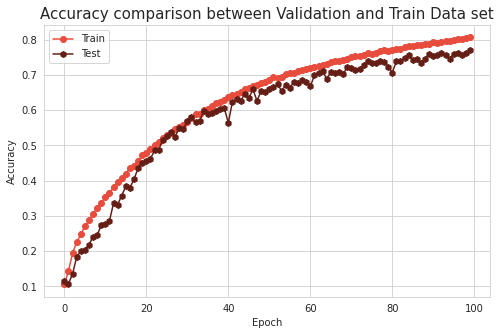

In [ ]:
acc_plot(vgg_sgdm)

**4. Visualizing loss in every epoch**

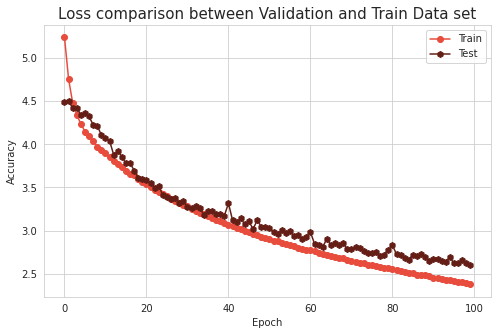

In [ ]:
loss_plot(vgg_sgdm)

**5. Visualizing Confusion Matrix**

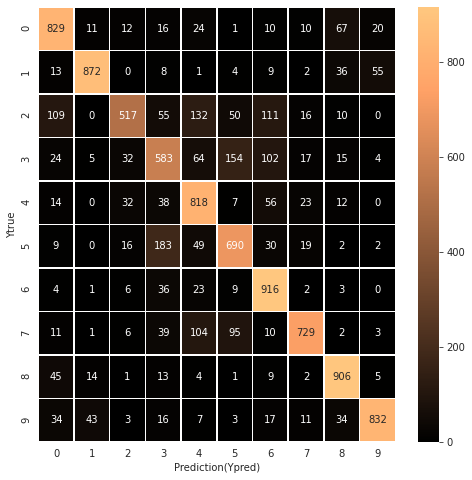

In [ ]:
display_cm(y_test, pred)

### **Training Model with Adam-Weight Decay Optimizer**

In [ ]:
model3 = vgg_model()
model3.compile(loss='categorical_crossentropy', optimizer=AdamW(0.001), metrics=['accuracy'])

In [ ]:
vgg_adamW = model3.fit(x_train, y_train, batch_size=500, epochs=50, validation_data=(x_test, y_test), shuffle=True)  #Original Epochs = 50

Epoch 1/50
100/100 [==============================] - 63s 218ms/step - loss: 5.1097 - accuracy: 0.1365 - val_loss: 4.4422 - val_accuracy: 0.1470
Epoch 2/50
100/100 [==============================] - 21s 215ms/step - loss: 4.2407 - accuracy: 0.2560 - val_loss: 4.0481 - val_accuracy: 0.2384
Epoch 3/50
100/100 [==============================] - 22s 219ms/step - loss: 3.8292 - accuracy: 0.3733 - val_loss: 3.7084 - val_accuracy: 0.3731
Epoch 4/50
100/100 [==============================] - 22s 223ms/step - loss: 3.5038 - accuracy: 0.4607 - val_loss: 3.3636 - val_accuracy: 0.4697
Epoch 5/50
100/100 [==============================] - 22s 225ms/step - loss: 3.2443 - accuracy: 0.5185 - val_loss: 3.1204 - val_accuracy: 0.5094
Epoch 6/50
100/100 [==============================] - 22s 225ms/step - loss: 2.9945 - accuracy: 0.5706 - val_loss: 3.0517 - val_accuracy: 0.5292
Epoch 7/50
100/100 [==============================] - 22s 223ms/step - loss: 2.7485 - accuracy: 0.6196 - val_loss: 2.7637 - val_ac

### **Performance Metrics Analysis for Model with AdamW Optimizer**

**1. Accuracy**

In [ ]:
perf_metrics_acc(model3)

Test Loss : 1.1140
Test Accuracy : 85.64 %


**2. Classification Report & Confusion Matrix**

In [ ]:
pred = model3.predict(x_test, batch_size = 32)
pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
per_metrics_2(y_test, pred)

*******************Classification Report*******************

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1000
           1       0.92      0.93      0.93      1000
           2       0.84      0.78      0.81      1000
           3       0.70      0.76      0.72      1000
           4       0.89      0.81      0.85      1000
           5       0.79      0.79      0.79      1000
           6       0.85      0.92      0.88      1000
           7       0.93      0.88      0.90      1000
           8       0.90      0.93      0.92      1000
           9       0.94      0.89      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

*******************Confusion Matrix*******************

[[890   9  16  12   3   6  10   3  43   8]
 [ 16 931   0   3   0   0   4   0  19  27]
 [ 46   0 784  47  27  32  48   7   7 

**3. Visualizing accuracy for every epoch**

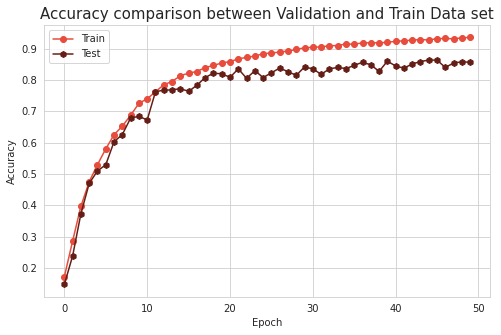

In [ ]:
acc_plot(vgg_adamW)

**4. Visualizing loss in every epoch**

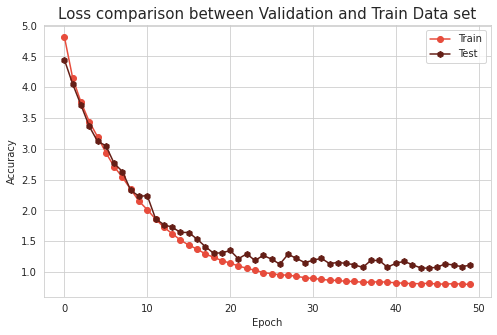

In [ ]:
loss_plot(vgg_adamW)

**5. Visualizing Confusion Matrix**

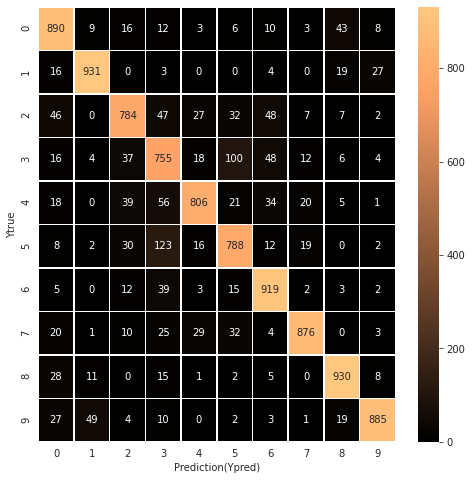

In [ ]:
display_cm(y_test, pred)

**6. Roc Curve**

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

In [ ]:
y_bin = label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8,9])
n_classes = y_bin.shape[1]
y_pred = label_binarize(pred, classes=[0,1,2,3,4,5,6,7,8,9])

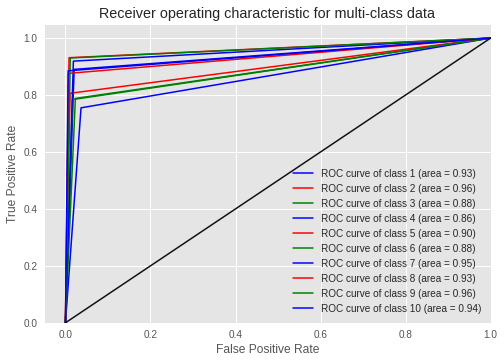

In [ ]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k-', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

**End.**